# ВНИМАНИЕ!

Следующее задание крайне рекомендуется выполнять в Google Colab, чтобы обеспечить отсутствие проблем с соединением при скачивании датасета, а также чтобы обеспечить скорость при обучении нейросети. 

https://colab.research.google.com/drive/1wYvjGhbuzsE3a_4Z95157gtw1Abj_UMl?usp=sharing

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import glob

In [2]:
torch.cuda.is_available()

True

# Transfer learning

На этом семинаре мы научимся очень быстро обучать нейросеть на сложную задачу классификации изображений, используя очень простой приём, именуемый fine tuning'ом. 

Для начала скачем датасет. На этот раз мы научим нейронку отличать кошечек от собачек.

In [3]:
! wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip && unzip kagglecatsanddogs_3367a.zip > /dev/null

--2021-11-07 19:11:54--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.72.240.114, 2a02:26f0:9500:894::e59, 2a02:26f0:9500:8a7::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.72.240.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  94.7MB/s    in 9.4s    

2021-11-07 19:12:05 (83.8 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



Удалим несколько битых изображений

In [4]:
! rm -rf ./PetImages/Cat/666.jpg ./PetImages/Dog/11702.jpg

Датасет разделим средствами pytorch'a на трейн и тест.

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

dataset = ImageFolder("./PetImages", transform=Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ]))
train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

Сделаем из скачанных датасетов даталоадеры

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

Посмотрим, как выглядят картинки.

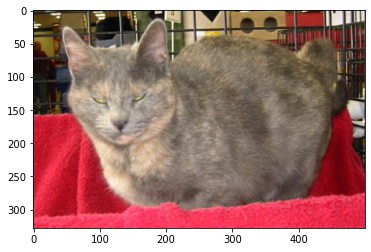

In [7]:

file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.imshow(plt.imread(file))

## Fine-Tuning

Кошки и собаки это конечно хорошо, вот только обучение модели, которая будет хорошо работать на этом датасете может оказаться очень долгим...

Однако картинки, которые мы сегодня рассмотрим оказываются очень похожими на картинки из огромного датасета ImageNet. Задача, которую мы сегодня рассмотрим, называется Transfer Learning -- в русскоязычной литературе иногда можно встретить термин "обучение с переносом знаний". Знания мы действительно переносим -- от сети, которая хорошо работает на одном датасете (ImageNet) к другим данным (к датасету Cats vs Dogs).

### Загрузим уже обученную сеть

В библиотеке `torchvision` имплементировано не только большое множество моделей (всевозможные ResNet'ы, Inception, VGG, AlexNet, DenseNet, ResNext, WideResNet, MobileNet...), но и загружены чекпоинты обучения этих моделей на ImageNet. Однако для датасета Cats vs Dogs такая штука является роскошью...

In [11]:
from torchvision.models import resnet18

# Загрузить предобученную сеть -- pretrained=True
model = resnet18(pretrained=True)

In [12]:
model

In [13]:
# YOUR CODE: "заморозьте" веса нейросети
# HINT: .requires_grad

В задаче transfer learning'a мы заменяем последний слой нейросети на линейный с двумя выходами.

In [15]:
model.fc = nn.Linear(512, 2)

Ниже несколько функций, которые мы уже видели в предыдущих семинарах.

In [16]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device='cuda:0',
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device='cuda:0'):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

In [17]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion,
            )
        # Save eval losses    
    return model

Создайте объект лосса и оптимизатор.

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = # YOUR CODE. It must optimize only across fully connected layer

In [21]:
model = model.cuda()

In [22]:
fit(model, 1, train_dataloader, test_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 0.6146 Accuracy: 66.4062:   1%|▏         | 1/79 [00:39<51:05, 39.30s/it]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "/home/user/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_445/4119386536.py", line 1, in <module>
    fit(model, 10, train_dataloader, test_dataloader, optimizer, criterion)
  File "/tmp/ipykernel_445/454647378.py", line 20, in fit
    criterion=criterion
  File "/tmp/ipykernel_445/1892887760.py", line 16, in train_epoch
    for images, labels in data_loader:
  File "/home/user/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 363, in __next__
    data = self._next_data()
  File "/home/user/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 403, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/user/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possi

TypeError: object of type 'NoneType' has no len()

Как видим на одну эпоху обучения уходит порядка двух минут, и уже после одной эпохи получается приемлемое качество. Давайте проинициализируем модель с нуля и попробуем обучить.

In [ ]:
model_full = resnet18(pretrained=False)
model_full.fc = nn.Linear(512, 2)
optimizer = # YOUR CODE. It must optimize across all parameters

In [ ]:
fit(model_full, 1, train_dataloader, test_dataloader, optimizer, criterion)